### Setup

If you want to write your own code and not follow this format, it is ok. Just make sure to use the same hyperparameters and models. If you see convergence sooner during the training, you may use fewer iterations.

In [38]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy

# Batch size
batch_size = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [39]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)

In [40]:
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time

### Plot one batch of data

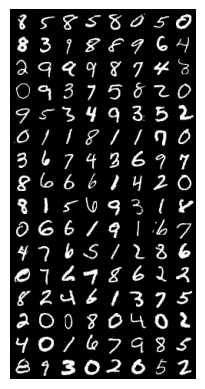

In [41]:
# Checking a sample batch and dataloader
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    plt.axis('off')
    plt.pause(0.001)  # pause a bit so that plots are updated
inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)

imshow(out)

## RealNVP

In [42]:
class RealNVP(nn.Module):
    def __init__(self, d):
        super(RealNVP, self).__init__()
        self.d = d
        # S
        self.fc1 = nn.Linear(d, 400)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 28*28-d)
        self.BN1 = nn.BatchNorm1d(400)

        # T
        self.fc4 = nn.Linear(d, 400)
        self.fc5 = nn.Linear(400, 400)
        self.fc6 = nn.Linear(400, 28*28-d)
    def S(self, x):
        x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
        output = self.fc3(x)
        return output

    def T(self, x):
        x = self.relu(self.fc4(x))
#         x = self.relu(self.fc5(x))
        output = self.fc6(x)
        return output

    def coupling(self, x):
        xa = x[:, 0:self.d]
        xb = x[:, self.d:]
        ya = xa
        t = self.T(xa)
        s = torch.tanh(self.S(xa))
        yb = torch.mul(xb, torch.exp(s)) + t
        y = torch.cat((ya,yb), dim=1)
        # calculate log det jacobian for computing loss
        log_det_Jacobian = torch.sum(s, -1)
        return torch.flip(y, dims=(1,)), log_det_Jacobian
    # Constructing the forward with 4 coupling
    def forward(self, x):
        x, loss1 = self.coupling(x)
        x, loss2 = self.coupling(x)
        x, loss3 = self.coupling(x)
        x, loss4 = self.coupling(x)
        loss = loss1 + loss2 + loss3 + loss4
        return x, loss

    def inverse_coupling(self, y):
        ya = y[:, 0:self.d]
        yb = y[:, self.d:]
        xa = ya
        t = self.T(ya)
        s = torch.tanh(self.S(ya))
        xb = torch.mul((yb-t), torch.exp(-s))
        x = torch.cat((xa,xb), dim=1)
        log_det_Jacobian = torch.sum(-s, -1)
        return torch.flip(x, dims=(1,)), log_det_Jacobian
    # calculating the reverse to be able to construct new data from random samples
    def reverse(self, y):
        x, loss1 = self.inverse_coupling(y)
        x, loss2 = self.inverse_coupling(x)
        x, loss3 = self.inverse_coupling(x)
        x, loss4 = self.inverse_coupling(x)
        loss = loss1 + loss2 + loss3 + loss4
        return x, loss
    # Loss function
    def loss_function(self, x):
        mean = torch.zeros(28*28).to(device)  # Mean of 0 for each dimension
        covariance_matrix = torch.eye(28*28).to(device)  # Identity covariance matrix

        # Create a multivariate normal distribution
        normal_dist = torch.distributions.MultivariateNormal(mean, covariance_matrix)
        z, ldj = self.forward(x)
        # loss of reconstruction and also loss of how much z is far from N(0,I)
        loss = -(normal_dist.log_prob(z)+ldj).mean()
        return loss

In [43]:
model = RealNVP(d=392).to(device)
optimizer = optim.Adam(model.parameters(), lr= 1e-5)
iter_max = 30
train_loss = np.zeros(iter_max)
test_loss = np.zeros(iter_max)
for i in tqdm(range(iter_max)):
    for batch_idx, (xu, yu) in enumerate(train_loader):

        optimizer.zero_grad()

        xu = xu.to(device).reshape(xu.size(0), -1)
        loss = model.loss_function(xu)/batch_size
        # print(" Loss = ", loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
        train_loss[i] = loss.cpu().detach().numpy()
    for batch_idx, (xu, yu) in enumerate(test_loader):
        optimizer.zero_grad()
        xu = xu.to(device).reshape(xu.size(0), -1)
        loss = model.loss_function(xu)/batch_size
        test_loss[i] = loss.cpu().detach().numpy()
    print(" Loss = ", train_loss[i])


  3%|▎         | 1/30 [00:13<06:29, 13.44s/it]

 Loss =  0.5454704165458679


  7%|▋         | 2/30 [00:27<06:19, 13.54s/it]

 Loss =  -1.3475234508514404


 10%|█         | 3/30 [00:40<06:03, 13.47s/it]

 Loss =  -2.1253514289855957


 13%|█▎        | 4/30 [00:54<05:51, 13.53s/it]

 Loss =  -2.348686695098877


 17%|█▋        | 5/30 [01:07<05:36, 13.46s/it]

 Loss =  -2.6203813552856445


 20%|██        | 6/30 [01:20<05:20, 13.37s/it]

 Loss =  -2.652757167816162


 23%|██▎       | 7/30 [01:33<05:06, 13.32s/it]

 Loss =  -3.0732693672180176


 27%|██▋       | 8/30 [01:47<04:54, 13.40s/it]

 Loss =  -3.10267972946167


 30%|███       | 9/30 [02:00<04:40, 13.38s/it]

 Loss =  -3.4226222038269043


 33%|███▎      | 10/30 [02:14<04:27, 13.39s/it]

 Loss =  -3.5477890968322754


 37%|███▋      | 11/30 [02:27<04:15, 13.44s/it]

 Loss =  -3.5585360527038574


 40%|████      | 12/30 [02:41<04:03, 13.54s/it]

 Loss =  -3.6594455242156982


 43%|████▎     | 13/30 [02:54<03:49, 13.50s/it]

 Loss =  -3.739826202392578


 47%|████▋     | 14/30 [03:08<03:36, 13.53s/it]

 Loss =  -3.8077304363250732


 50%|█████     | 15/30 [03:21<03:22, 13.51s/it]

 Loss =  -3.885079860687256


 53%|█████▎    | 16/30 [03:35<03:09, 13.53s/it]

 Loss =  -3.914210081100464


 57%|█████▋    | 17/30 [03:49<02:55, 13.54s/it]

 Loss =  -4.028989791870117


 60%|██████    | 18/30 [04:02<02:42, 13.52s/it]

 Loss =  -4.049455642700195


 63%|██████▎   | 19/30 [04:15<02:28, 13.50s/it]

 Loss =  -4.199456214904785


 67%|██████▋   | 20/30 [04:29<02:15, 13.50s/it]

 Loss =  -4.215601921081543


 70%|███████   | 21/30 [04:42<02:01, 13.50s/it]

 Loss =  -4.330699920654297


 73%|███████▎  | 22/30 [04:56<01:48, 13.50s/it]

 Loss =  -4.2163286209106445


 77%|███████▋  | 23/30 [05:09<01:34, 13.48s/it]

 Loss =  -4.277820587158203


 80%|████████  | 24/30 [05:23<01:20, 13.43s/it]

 Loss =  -4.369376182556152


 83%|████████▎ | 25/30 [05:36<01:06, 13.40s/it]

 Loss =  -4.324342727661133


 87%|████████▋ | 26/30 [05:50<00:54, 13.52s/it]

 Loss =  -4.330566883087158


 90%|█████████ | 27/30 [06:03<00:40, 13.49s/it]

 Loss =  -4.441479682922363


 93%|█████████▎| 28/30 [06:17<00:27, 13.55s/it]

 Loss =  -4.485103130340576


 97%|█████████▋| 29/30 [06:30<00:13, 13.50s/it]

 Loss =  -4.510962009429932


100%|██████████| 30/30 [06:44<00:00, 13.47s/it]

 Loss =  -4.379727840423584


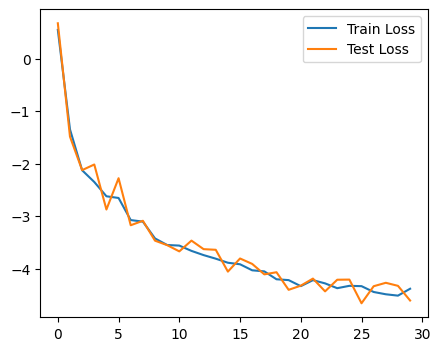

In [44]:
## Plot Loss per epoch for train and test
plt.figure(figsize=(5,4))
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

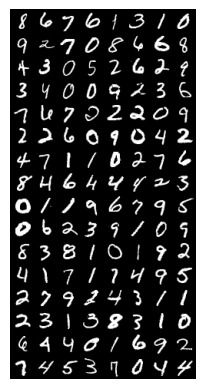

In [45]:
x, _ = next(iter(test_loader))
out = torchvision.utils.make_grid(x)

imshow(out)

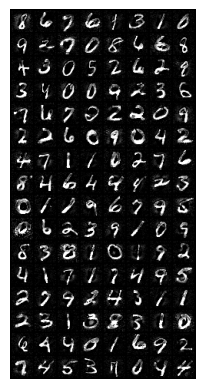

In [46]:
x = x.to(device).reshape(x.size(0), -1)
z, _ = model.forward(x)
recon_x, _ = model.reverse(z)
recon_x = recon_x.cpu().reshape([batch_size,1,28,28])
out = torchvision.utils.make_grid(recon_x)

imshow(out)

In [47]:
model.eval()
with torch.no_grad():
    z_samples = torch.randn(16, 28*28).to(device)  # Sample from a standard normal distribution

    # Reverse the order of flows for generation
    x_gen, _ = model.reverse(z_samples)


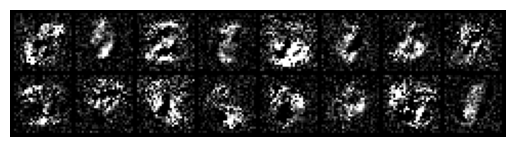

In [48]:
recon_x = x_gen.cpu().reshape([16,1,28,28])
out = torchvision.utils.make_grid(recon_x)

imshow(out)